In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add current directory to path to import readBLOT
sys.path.append(os.getcwd())
try:
    from readBLOT import read_blot_data
except ImportError:
    # Fallback if running relative
    sys.path.append('.')
    from readBLOT import read_blot_data

sns.set_theme(style="whitegrid")

In [15]:
# Load Data
df = read_blot_data('blot.txt')
print(f"Data Loaded: {df.shape}")
print(df.head())

# Identify item columns (exclude PersonID if present)
# Based on readBLOT.py behavior in previous turns, it likely returns a DataFrame with 'PersonID' and items.
item_cols = [c for c in df.columns if c != 'PersonID']
print(f"Number of Items: {len(item_cols)}")

Data Loaded: (150, 36)
  PersonID  1_Negation  2_Reciproc  3_Implicat  4_Incompat  5_MultComp  \
0      001           1           1           1           1           1   
1      002           1           1           1           1           1   
2      003           1           1           0           1           0   
3      004           1           1           1           1           1   
4      005           1           1           1           1           1   

   6_Correlat  7_Correlat  8_Correlat  9_Conjunct  ...  26_ComplAff  \
0           1           1           1           1  ...            1   
1           1           1           1           1  ...            1   
2           1           1           1           1  ...            1   
3           1           1           1           1  ...            1   
4           1           1           1           1  ...            1   

   27_Neg of p  28_Non-impl  29_Aff of q  30_Equiv  31_Neg of q  \
0            1            1           

In [16]:
# Debugging Score Calculation
# Check if selecting by column list with duplicate names causes issues
selected_cols = df[item_cols]
print(f"Original DataFrame Shape: {df.shape}")
print(f"Item Columns List Length: {len(item_cols)}")
print(f"Shape of df[item_cols]: {selected_cols.shape}")

# Check sum stats
raw_sums = selected_cols.sum(axis=1)
print(f"Max Score by name selection: {raw_sums.max()}")

# Alternative: Select by logical exclusion of PersonID (if it's the first column, or by index)
# Assuming PersonID is column 0
items_by_pos = df.iloc[:, 1:]
print(f"Shape of df.iloc[:, 1:]: {items_by_pos.shape}")
print(f"Max Score by position: {items_by_pos.sum(axis=1).max()}")

Original DataFrame Shape: (150, 36)
Item Columns List Length: 35
Shape of df[item_cols]: (150, 35)
Max Score by name selection: 35
Shape of df.iloc[:, 1:]: (150, 35)
Max Score by position: 35


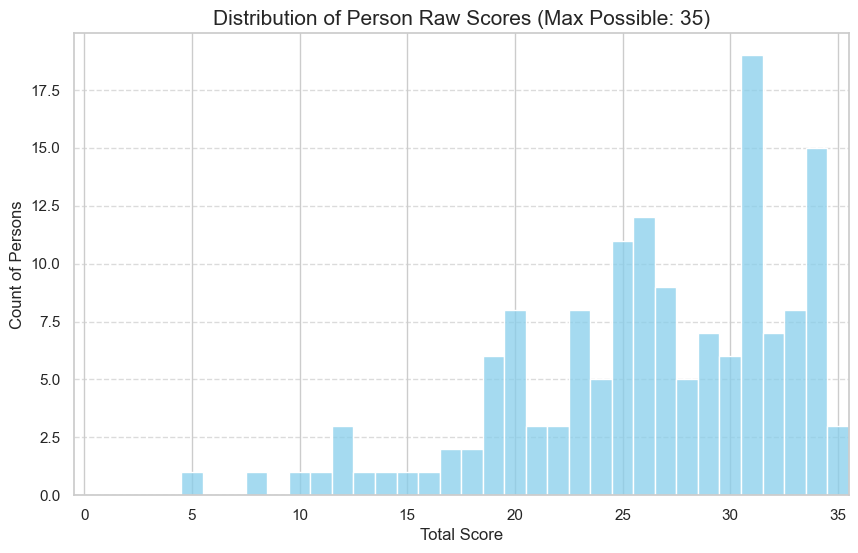

In [17]:
# Plot 1: Person Scores Distribution
# Calculate scores using positional indexing to avoid duplicate column name issues
person_scores = df.iloc[:, 1:].sum(axis=1)

# Theoretical max score is number of items
max_score = df.shape[1] - 1

plt.figure(figsize=(10, 6))
# Histogram with discrete bins
sns.histplot(person_scores, discrete=True, color='skyblue', binrange=(0, max_score))
plt.title(f'Distribution of Person Raw Scores (Max Possible: {max_score})', fontsize=15)
plt.xlabel('Total Score')
plt.ylabel('Count of Persons')

# Set X-axis to cover full potential range [0, 35]
plt.xlim(-0.5, max_score + 0.5)
plt.xticks(range(0, max_score + 1, 5)) # Tick every 5 units

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Items by position: 35
Scores Length: 35


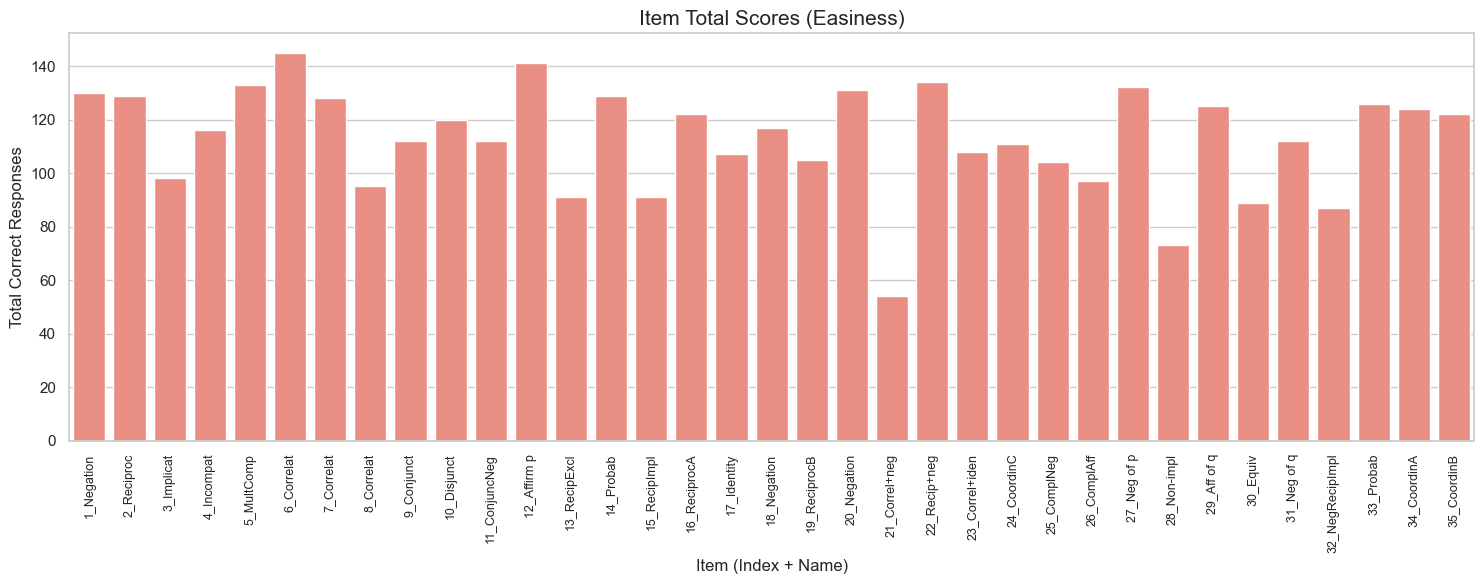

In [18]:
# Plot 2: Item Scores Distribution
# Use iloc to avoid issues with duplicate column names
# Assuming first column is ID and rest are items.
item_data = df.iloc[:, 1:] 
item_scores = item_data.sum(axis=0)

num_items = item_data.shape[1]
print(f"Items by position: {num_items}")
print(f"Scores Length: {len(item_scores)}")

# Create labels with "Index Name" format
item_names = item_data.columns
item_labels = [f"{name}" for i, name in enumerate(item_names)]

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'ItemIndex': range(num_items),
    'Score': item_scores.values
})

plt.figure(figsize=(15, 6))
sns.barplot(data=plot_df, x='ItemIndex', y='Score', color='salmon')

# Set X-Ticks
plt.xticks(
    ticks=range(num_items), 
    labels=item_labels, 
    rotation=90, 
    ha='center',
    fontsize=9
)

plt.title('Item Total Scores (Easiness)', fontsize=15)
plt.xlabel('Item (Index + Name)')
plt.ylabel('Total Correct Responses')
plt.tight_layout()
plt.show()

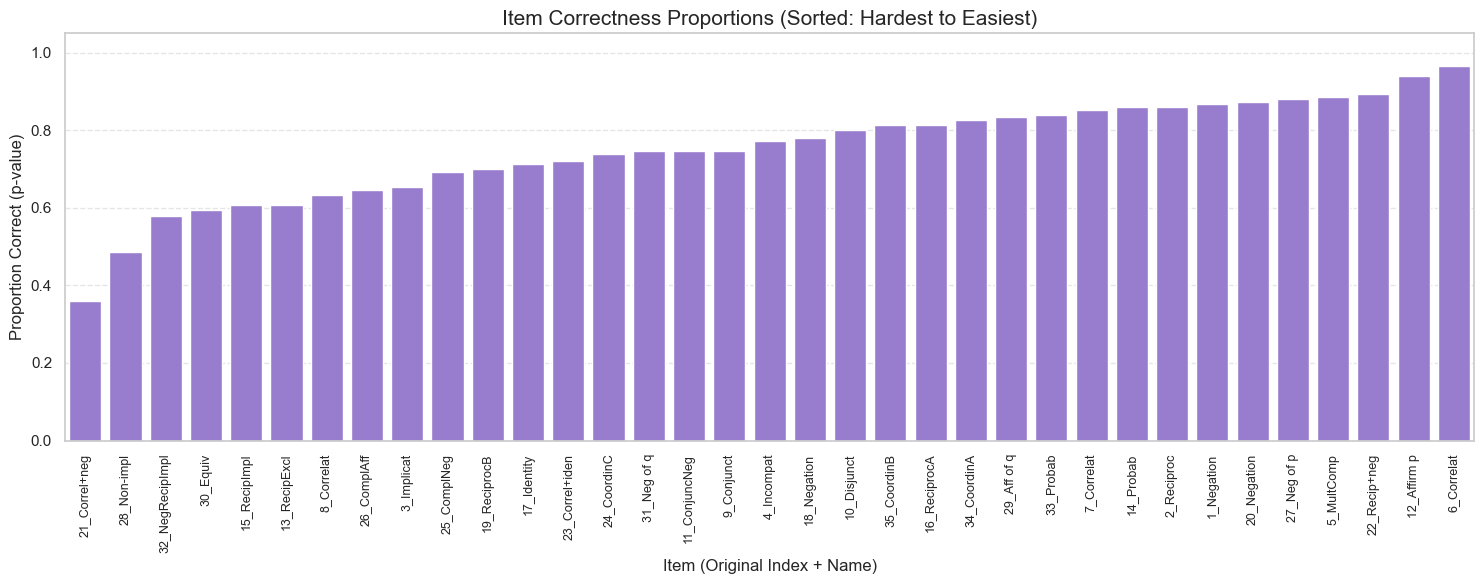

In [19]:
# Plot 3: Item Scores (Sorted by Difficulty/Easiness) as Proportions
# Calculate proportions
n_persons = df.shape[0]
item_data = df.iloc[:, 1:]
item_props = item_data.sum(axis=0) / n_persons

# Create DataFrame for sorting
# Sort by Proportion Ascending (Lowest/Hardest on Left -> Highest/Easiest on Right)
item_df_sorted = pd.DataFrame({
    'OriginalIndex': range(1, len(item_props) + 1),
    'Name': item_data.columns,
    'Proportion': item_props.values
}).sort_values('Proportion')

# Create labels for the sorted x-axis
labels_sorted = [f"{row.Name}" for _, row in item_df_sorted.iterrows()]

plt.figure(figsize=(15, 6))
# Plot bars in the sorted order
sns.barplot(x=list(range(len(item_props))), y=item_df_sorted['Proportion'], color='mediumpurple')

# Set X-Ticks
plt.xticks(
    ticks=range(len(item_props)), 
    labels=labels_sorted, 
    rotation=90, 
    ha='center',
    fontsize=9
)

plt.title('Item Correctness Proportions (Sorted: Hardest to Easiest)', fontsize=15)
plt.xlabel('Item (Original Index + Name)')
plt.ylabel('Proportion Correct (p-value)')
plt.ylim(0, 1.05) 
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

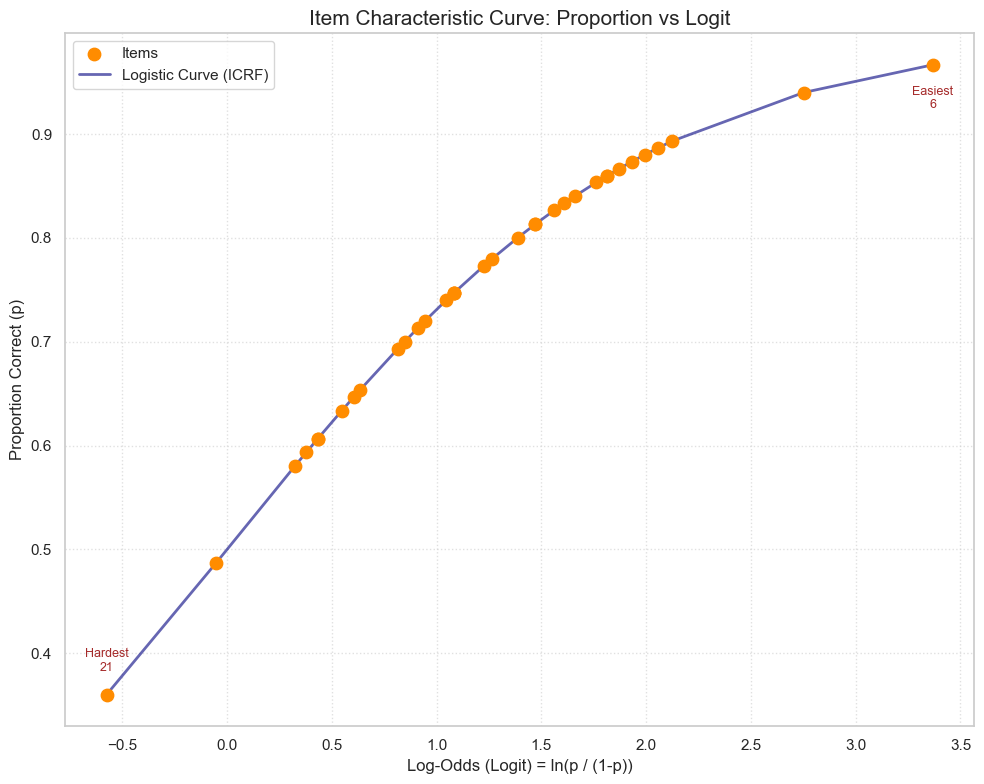

In [20]:
# Plot 4: Proportion Correct vs Log-Odds (The Logistic Curve)
import numpy as np # Ensure numpy is imported

# This plot visualizes the transformation from logit scale to proportions (Logistic Curve).
# X-Axis: Log-Odds / Difficulty
# Y-Axis: Probability / Proportion

# Use the sorted item dataframe from previous step
p = item_df_sorted['Proportion'].clip(0.001, 0.999) 
q = 1 - p
logits = np.log(p / q)

plt.figure(figsize=(10, 8))

# Plot Points (Swapped Axes)
plt.scatter(logits, p, color='darkorange', s=80, label='Items', zorder=5)

# Connect consecutive points
plt.plot(logits, p, color='navy', linestyle='-', linewidth=2, alpha=0.6, label='Logistic Curve (ICRF)')

# Annotation for specific items
# Hardest (First in sorted -> Lowest Prop -> Lowest Logit)
# Position text relative to the point
plt.text(logits.iloc[0], p.iloc[0] + 0.02, f"Hardest\n{item_df_sorted.iloc[0]['OriginalIndex']}", 
         ha='center', va='bottom', fontsize=9, color='brown')

# Easiest (Last in sorted -> Highest Prop -> Highest Logit)
plt.text(logits.iloc[-1], p.iloc[-1] - 0.02, f"Easiest\n{item_df_sorted.iloc[-1]['OriginalIndex']}", 
         ha='center', va='top', fontsize=9, color='brown')

plt.title('Item Characteristic Curve: Proportion vs Logit', fontsize=15)
plt.xlabel('Log-Odds (Logit) = ln(p / (1-p))')
plt.ylabel('Proportion Correct (p)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

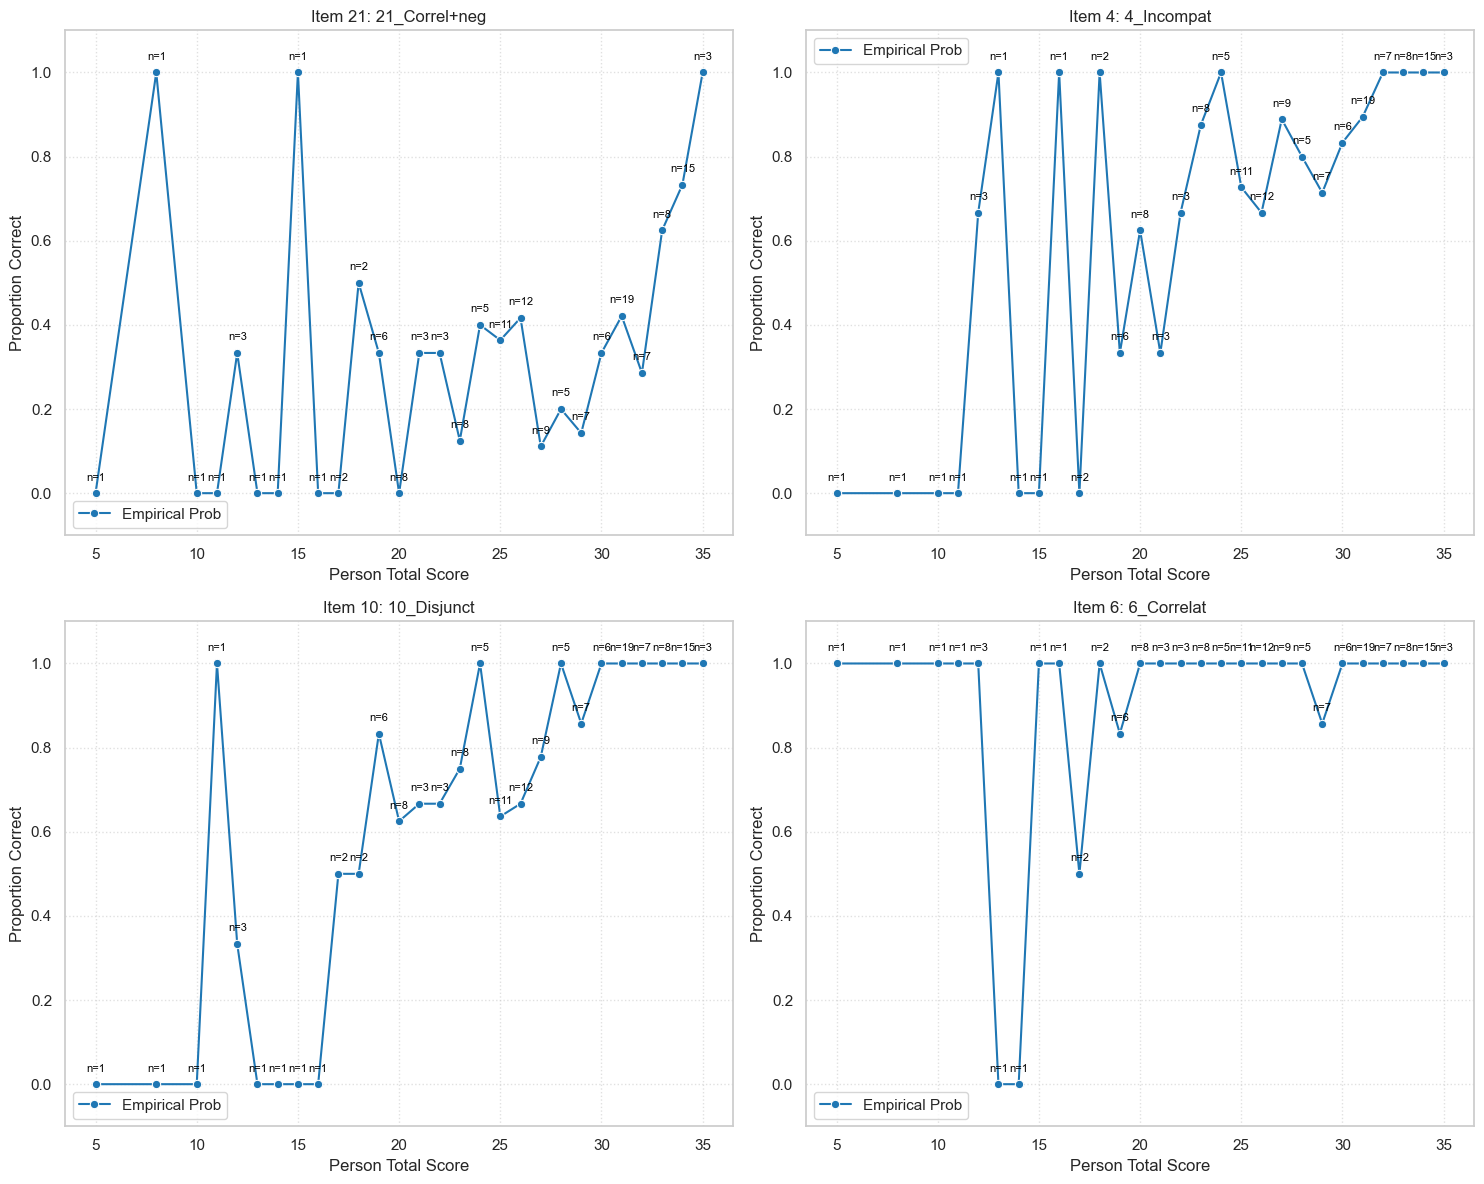

In [29]:
# Plot 7: Investigation of Item Empirical ICC for Select Items
# Users: 21, 4, 10, 6

target_items = [21, 4, 10, 6] 

# 1. Prepare Person Scores
# Make sure exclude any non-item columns. We already did this in 'total_score' calculation later,
# but let's be safe here.
# item_cols is likely defined as all cols except PersonID.
# But we added TotalScore/LogitScore to df later.
non_item_cols = {'PersonID', 'TotalScore', 'LogitScore'}
item_cols_clean = [c for c in df.columns if c not in non_item_cols]

person_total_scores = df[item_cols_clean].sum(axis=1)

# 2. Setup Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, item_idx_1based in enumerate(target_items):
    # Get column name. item_cols_clean is 0-indexed list of names
    # item_idx_1based assumes 1..35
    col_name = item_cols_clean[item_idx_1based - 1]
    
    item_responses = df[col_name]
    
    # Create DF for aggregation
    icc_df = pd.DataFrame({
        'TotalScore': person_total_scores,
        'Response': item_responses
    })
    
    # Aggregate
    grouped_icc = icc_df.groupby('TotalScore')['Response'].agg(['mean', 'count']).reset_index()
    grouped_icc = grouped_icc.rename(columns={'mean': 'ProportionCorrect', 'count': 'N'})
    
    # Plot on subplot
    ax = axes[idx]
    sns.lineplot(data=grouped_icc, x='TotalScore', y='ProportionCorrect', marker='o', ax=ax, label='Empirical Prob', color='tab:blue')
    
    # Sample Size Annotation (only for points with N < 10 to reduce clutter, or spaced out?)
    # Just annotating all:
    for _, row in grouped_icc.iterrows():
        ax.text(row['TotalScore'], row['ProportionCorrect'] + 0.03, f"n={int(row['N'])}", 
                 ha='center', fontsize=8, color='black')
        
    ax.set_title(f'Item {item_idx_1based}: {col_name}')
    ax.set_xlabel('Person Total Score')
    ax.set_ylabel('Proportion Correct')
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True, linestyle=':', alpha=0.6)
    
plt.tight_layout()
plt.show()

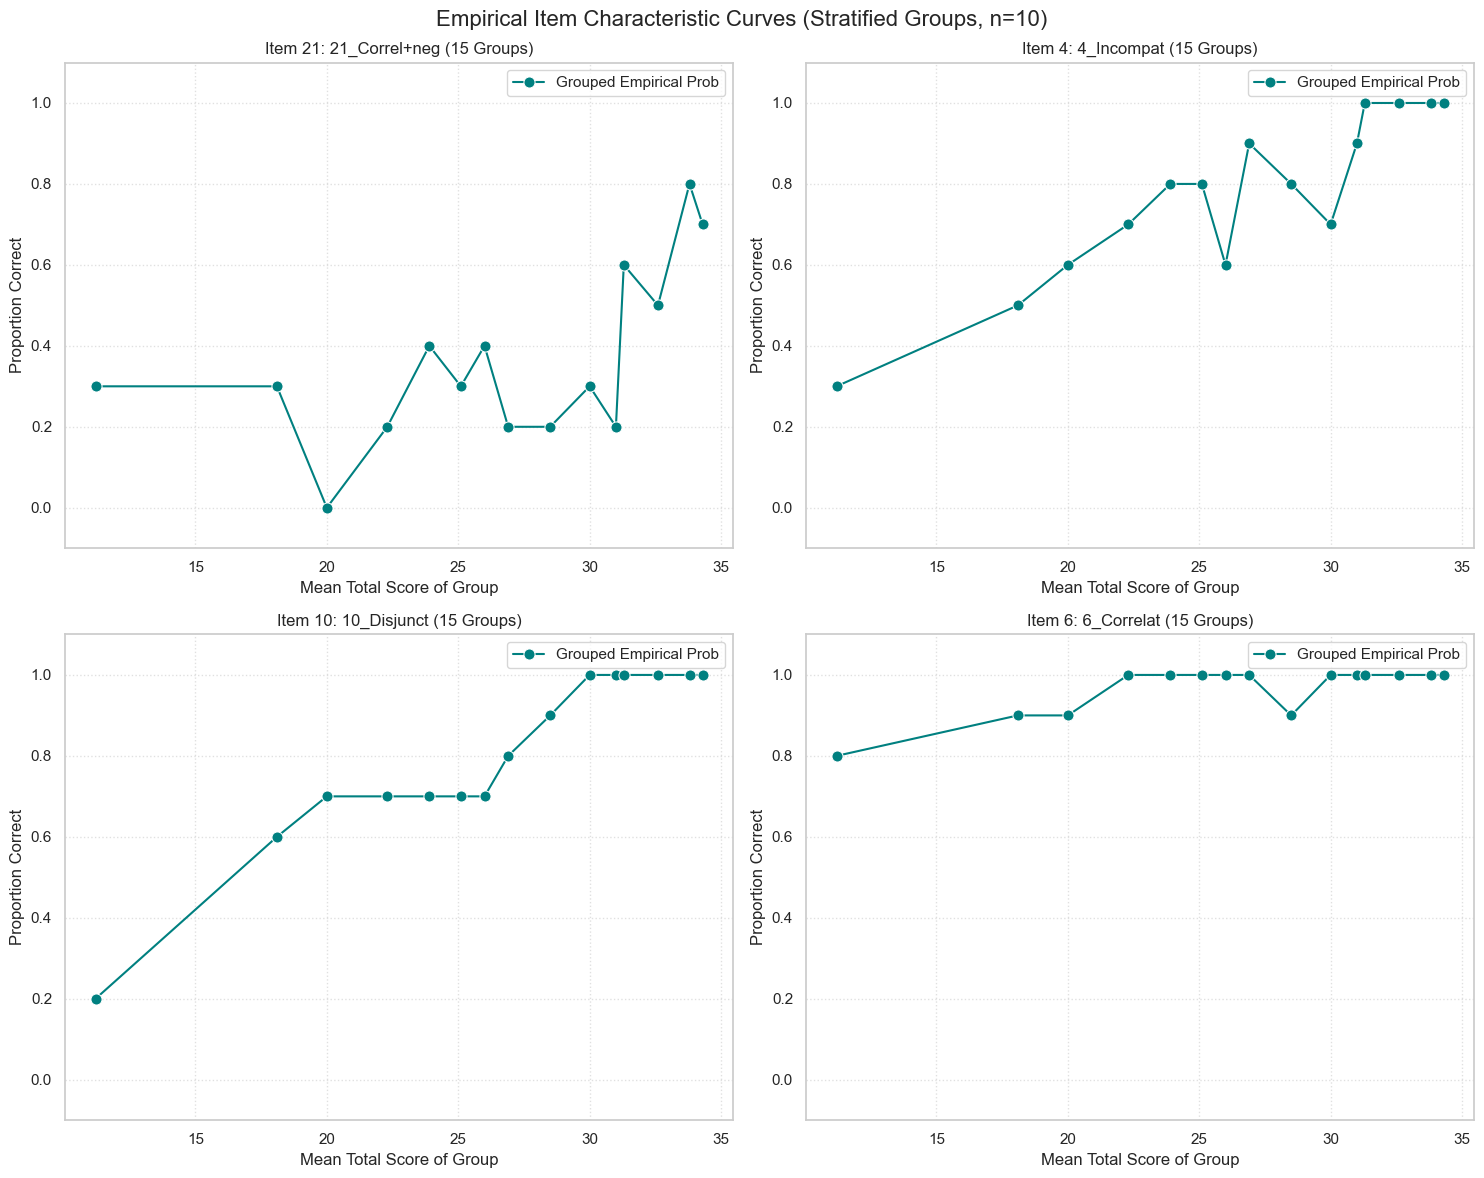

In [30]:
# Plot 7b: Empirical ICC with Stratified Groups (15 groups of 10 students)
# Use sorted groups to smooth out the noise from individual scores

# 1. Sort Data by Total Score
# Use a copy to avoid modifying original df mid-analysis if not needed
df_grouped = df.sort_values('TotalScore').reset_index(drop=True)

# 2. Assign Groups (15 groups of 10 students = 150 students)
n_groups = 15
# Create labels: 10 of '1', 10 of '2', etc.
group_labels = np.repeat(np.arange(1, n_groups + 1), 10)

# Validate size matches (Expect 150)
if len(df_grouped) == len(group_labels):
    df_grouped['RankGroup'] = group_labels
else:
    print(f"Warning: Dataset size {len(df_grouped)} != group label size {len(group_labels)}. Using quantile cut.")
    df_grouped['RankGroup'] = pd.qcut(df_grouped.index, q=n_groups, labels=range(1, n_groups + 1))

# 3. Define Items
target_items = [21, 4, 10, 6]
# Robustly identify item columns (excluding calculated scores/metadata)
non_item_cols = {'PersonID', 'TotalScore', 'LogitScore', 'RankGroup', 'Proportion', 'LogitProportion', 'GroupType'}
item_cols_clean = [c for c in df.columns if c not in non_item_cols]

# 4. Plot Setup
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, item_idx_1based in enumerate(target_items):
    # Get column name
    col_name = item_cols_clean[item_idx_1based - 1]
    
    # Aggregate Means per Group
    group_stats = df_grouped.groupby('RankGroup').agg({
        'TotalScore': 'mean',
        col_name: 'mean'
    }).reset_index()
    group_stats = group_stats.rename(columns={col_name: 'ProportionCorrect'})
    
    # Plot Line
    ax = axes[idx]
    sns.lineplot(data=group_stats, x='TotalScore', y='ProportionCorrect', 
                 marker='o', markersize=8, ax=ax, color='teal', label='Grouped Empirical Prob')
    
    # Optional: Plot individual points lightly for context (commented out to keep clean as requested)
    # sns.scatterplot(data=df, x='TotalScore', y=col_name, ax=ax, color='gray', alpha=0.1, s=10)

    ax.set_title(f'Item {item_idx_1based}: {col_name} (15 Groups)', fontsize=12)
    ax.set_xlabel('Mean Total Score of Group')
    ax.set_ylabel('Proportion Correct')
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True, linestyle=':', alpha=0.6)

plt.suptitle(f'Empirical Item Characteristic Curves (Stratified Groups, n=10)', fontsize=16)
plt.tight_layout()
plt.show()

### Corrected Item-Total Correlations (Discrimination)

*   **What it is:** The correlation between how a person answered a specific item and their total score on _all other_ items.
*   **Why it helps:** This is a proxy for item discrimination. High correlation means the item discriminates well between high and low ability students. Low (or negative) correlation suggests the item might be confusing, miskeyed, or measuring a different construct.

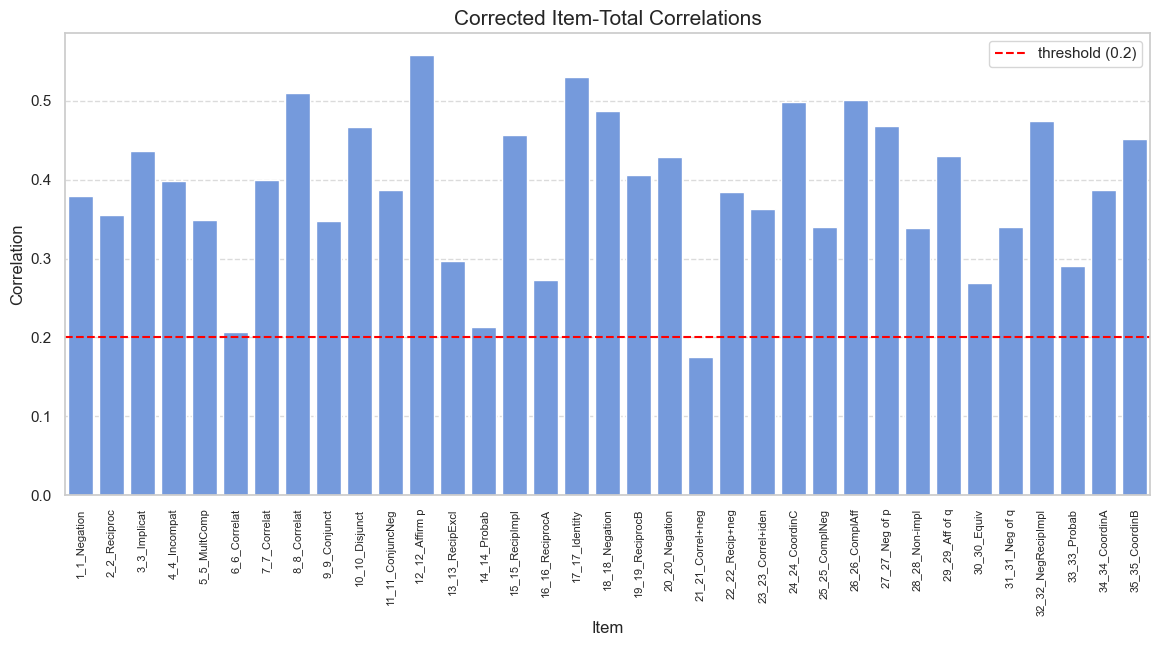

Items with low discrimination (< 0.2):
                Item  Correlation
20  21_21_Correl+neg     0.175688


In [22]:
# Plot 9: Item-Total Correlations (Discrimination)
# We calculate the correlation between each item and the total score.
# Ideally, we use "Corrected Item-Total Correlation" (Total Score excluding the item itself)
# to avoid inflating the correlation.

correlations = []
# Use iloc to handle potential duplicate column names safely
item_data_only = df.iloc[:, 1:] 
n_items = item_data_only.shape[1]

# Calculate total score of all items first
all_items_total = item_data_only.sum(axis=1)

for col_idx in range(n_items):
    # Select by position to avoid duplicate name issues
    item_responses = item_data_only.iloc[:, col_idx]
    item_name = item_data_only.columns[col_idx]
    
    # Calculate corrected total: Total - Item Score
    corrected_total = all_items_total - item_responses.fillna(0)
    
    # Check if item is constant (variance 0) to avoid NaN
    if item_responses.std() == 0:
        corr = 0
    else:
        corr = item_responses.corr(corrected_total)
    
    # Use index + name for clearer label
    label = f"{col_idx+1}_{item_name}"
    correlations.append({'Item': label, 'Correlation': corr})

corr_df = pd.DataFrame(correlations)

# Plot
plt.figure(figsize=(14, 6))

sns.barplot(data=corr_df, x='Item', y='Correlation', color='cornflowerblue')
plt.title('Corrected Item-Total Correlations', fontsize=15)
plt.axhline(0.2, color='red', linestyle='--', label='threshold (0.2)') # Common cutoff

# Set X-labels
plt.xticks(
    rotation=90, 
    fontsize=8
)
plt.xlabel("Item")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# List items with low discrimination
low_discrim = corr_df[corr_df['Correlation'] < 0.2]
if not low_discrim.empty:
    print("Items with low discrimination (< 0.2):")
    print(low_discrim)
else:
    print("All items have discrimination > 0.2")

### Guttman Scalogram (Response Matrix Heatmap)

*   **What it is:** A heatmap of the raw data, sorted by Person Score (rows) and Item Difficulty (columns).
*   **Why it helps:** In a perfect Guttman scale, you should see a "triangular" pattern of correct responses (1s) in the top-left and incorrect responses (0s) in the bottom-right. Deviations (like 0s in the sea of 1s or 1s in the sea of 0s) highlight "unexpected" responses or misfitting items/persons.

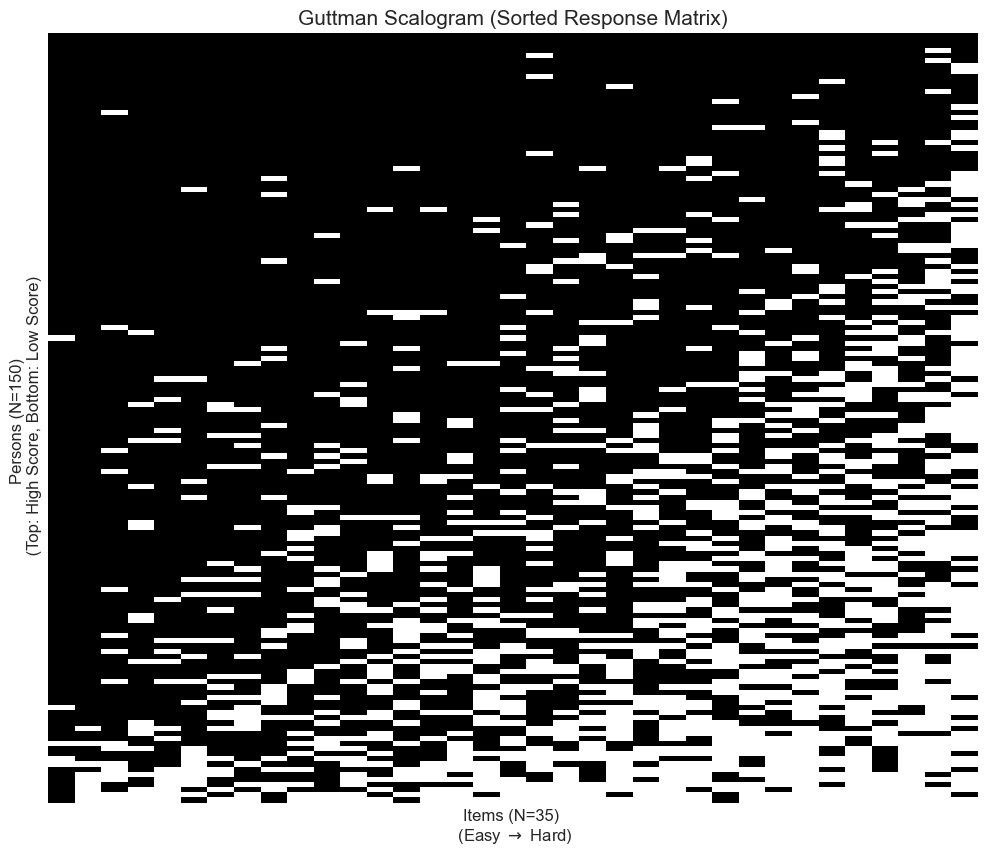

In [23]:
# Plot 8: Guttman Scalogram (Response Matrix Heatmap)
# Sort persons by total score (descending) and items by correctness (descending)
# This visualization helps check for the Guttman pattern (triangle of 1s in top-left)
# and identify unexpected response patterns.

# 1. Prepare Data
# Ensure we strictly select the 35 items (Columns 1 to 35)
# This safeguards against any extra columns that might be present in the DataFrame
response_matrix = df.iloc[:, 1:36].copy() 

person_scores = response_matrix.sum(axis=1)
item_difficulties = response_matrix.mean(axis=0) # Measure as proportion correct (easiness)

# 2. Sort
# Sort persons: highest score first
sorted_persons_idx = person_scores.sort_values(ascending=False).index
response_matrix_sorted = response_matrix.loc[sorted_persons_idx]

# Sort items: easiest (highest mean) first
sorted_items_idx = item_difficulties.sort_values(ascending=False).index
response_matrix_sorted = response_matrix_sorted[sorted_items_idx]

# 3. Plot
plt.figure(figsize=(12, 10))
sns.heatmap(response_matrix_sorted, 
            cbar=False, 
            cmap="Greys", 
            xticklabels=False, 
            yticklabels=False)

plt.title('Guttman Scalogram (Sorted Response Matrix)', fontsize=15)
plt.ylabel(f'Persons (N={len(response_matrix_sorted)}) \n (Top: High Score, Bottom: Low Score)')
plt.xlabel(f'Items (N={response_matrix_sorted.shape[1]}) \n (Easy $\\rightarrow$ Hard)')
plt.show()

In [24]:
response_matrix_sorted.iloc[-1,:].sum()

5

Corrected Number of Items: 35


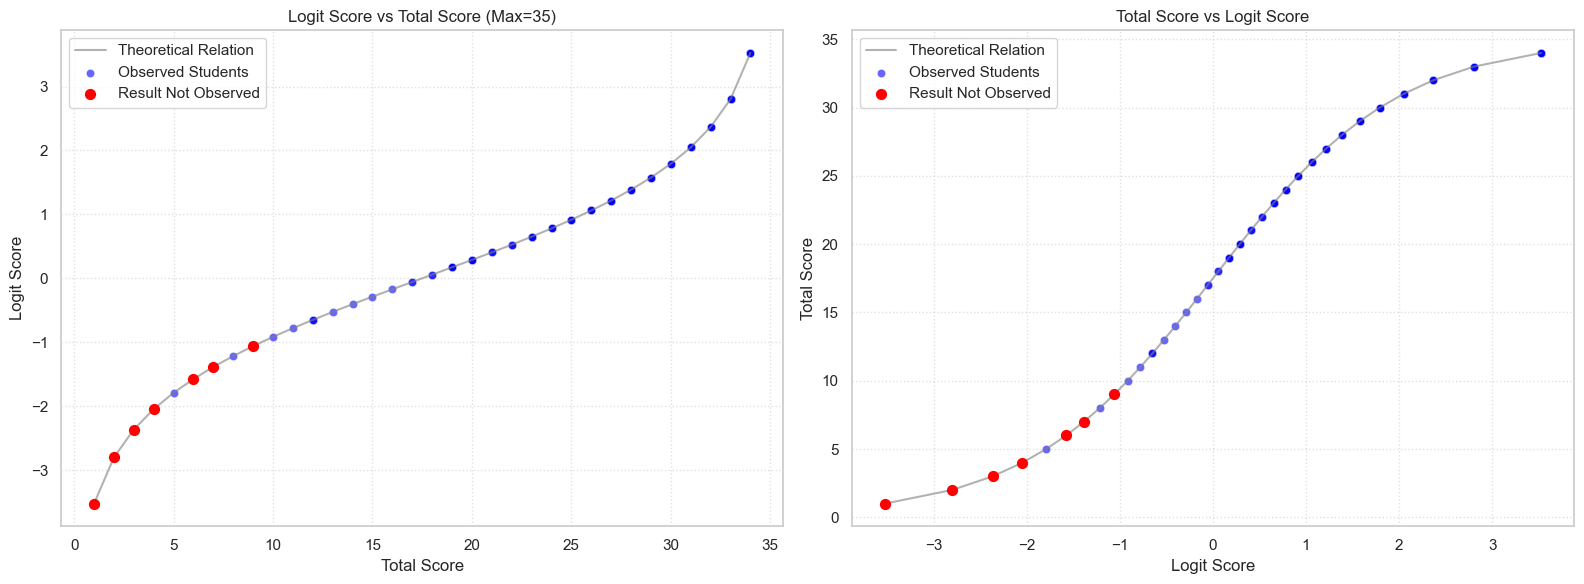

Note: 3 students had extreme scores (0 or 35) and have undefined logits.
Scores within range [1, 34] that no student achieved: [1 2 3 4 6 7 9]


In [25]:
import numpy as np

# Calculate Total Score for each student
# EXPLANATION OF FIX: 
# Previously, we selected all columns != 'PersonID'. 
# When this cell was re-run, 'TotalScore' and 'LogitScore' (added by this cell) were included in 'item_cols'.
# This caused the item count to grow (e.g., to 37) and the score to be summed incorrectly.
# We now strictly exclude known non-item columns.
non_item_cols = {'PersonID', 'TotalScore', 'LogitScore'}
item_cols = [c for c in df.columns if c not in non_item_cols]

# Recalculate based on fixed item columns
total_score = df[item_cols].sum(axis=1)
max_score = len(item_cols)

print(f"Corrected Number of Items: {max_score}") # Should be 35

# Compute Logit: log(score / (max - score))
with np.errstate(divide='ignore', invalid='ignore'):
    logit_score = np.log(total_score / (max_score - total_score))

# Store/Overwrite in DataFrame
df['TotalScore'] = total_score
df['LogitScore'] = logit_score

# Filter out infinite values for the plot (observed data)
plot_data = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['LogitScore'])

# --- Theoretical Calculations for Scores 1 to 34 (Max Score - 1) ---
theoretical_scores = np.arange(1, max_score) 
with np.errstate(divide='ignore', invalid='ignore'):
    theoretical_logits = np.log(theoretical_scores / (max_score - theoretical_scores))

# Identify scores NOT present in the observed data
observed_scores_set = set(plot_data['TotalScore'].astype(int))
missing_indices = [i for i, s in enumerate(theoretical_scores) if s not in observed_scores_set]
missing_scores = theoretical_scores[missing_indices]
missing_logits = theoretical_logits[missing_indices]

# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Logit Score vs Total Score
axes[0].plot(theoretical_scores, theoretical_logits, color='gray', linestyle='-', alpha=0.6, label='Theoretical Relation')
sns.scatterplot(data=plot_data, x='TotalScore', y='LogitScore', ax=axes[0], color='blue', label='Observed Students', alpha=0.6)
if len(missing_scores) > 0:
    axes[0].scatter(missing_scores, missing_logits, color='red', s=50, zorder=5, label='Result Not Observed')

axes[0].set_title(f'Logit Score vs Total Score (Max={max_score})')
axes[0].set_xlabel('Total Score')
axes[0].set_ylabel('Logit Score')
axes[0].legend()
axes[0].grid(True, linestyle=':', alpha=0.6)

# Plot 2: Total Score vs Logit Score
axes[1].plot(theoretical_logits, theoretical_scores, color='gray', linestyle='-', alpha=0.6, label='Theoretical Relation')
sns.scatterplot(data=plot_data, x='LogitScore', y='TotalScore', ax=axes[1], color='blue', label='Observed Students', alpha=0.6)
if len(missing_scores) > 0:
    axes[1].scatter(missing_logits, missing_scores, color='red', s=50, zorder=5, label='Result Not Observed')

axes[1].set_title(f'Total Score vs Logit Score')
axes[1].set_xlabel('Logit Score')
axes[1].set_ylabel('Total Score')
axes[1].legend()
axes[1].grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

# Report
undefined_count = len(df) - len(plot_data)
if undefined_count > 0:
    print(f"Note: {undefined_count} students had extreme scores (0 or {max_score}) and have undefined logits.")
if len(missing_scores) > 0:
    print(f"Scores within range [1, {max_score-1}] that no student achieved: {missing_scores}")

Adding Virtual Group: Prop=0.1, Score=3.50, Logit=-2.20
Group Statistics (Head):
         TotalScore  LogitScore  Proportion  LogitProportion GroupType
Virtual         3.5         NaN    0.100000        -2.197225   Virtual
1              11.2   -0.787561    0.320000        -0.753772  Observed
2              18.1    0.068740    0.517143         0.068598  Observed
3              20.0    0.287877    0.571429         0.287682  Observed
4              22.3    0.564215    0.637143         0.562985  Observed


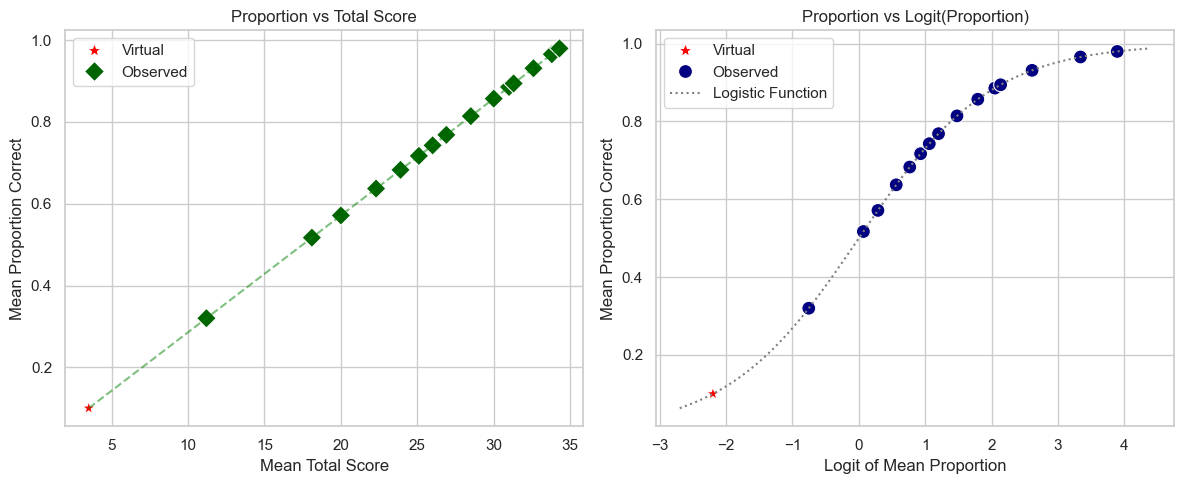

In [28]:
# Group Analysis: 15 groups of 10 students ordered by Total Score
# 1. Sort Data
df_sorted = df.sort_values('TotalScore').reset_index(drop=True)

# 2. Create Groups
# We have 150 students. 15 groups * 10 students = 150.
n_groups = 15
students_per_group = 10
# Create group labels [1,1,..,1, 2,2,..,2, ...]
group_labels = np.repeat(np.arange(1, n_groups + 1), students_per_group)

# Handle case if len(df) is not exactly 150 (though we know it is)
if len(df_sorted) == len(group_labels):
    df_sorted['RankGroup'] = group_labels
else:
    # Approximate grouping if size mismatches (fallback)
    df_sorted['RankGroup'] = pd.qcut(df_sorted.index, q=n_groups, labels=range(1, n_groups + 1))

# 3. Compute Group Means
group_stats = df_sorted.groupby('RankGroup')[['TotalScore', 'LogitScore']].mean()

# Calculate Proportion (Mean Score / Max Score)
# Ensure max_score is correct (35)
max_score = 35 # or len(item_cols)
group_stats['Proportion'] = group_stats['TotalScore'] / max_score

# Calculate Logit of Proportion: ln(p / (1-p))
p_safe = group_stats['Proportion'].clip(0.001, 0.999)
group_stats['LogitProportion'] = np.log(p_safe / (1 - p_safe))

# --- Add Virtual Group (Proportion = 0.1) ---
virtual_prop = 0.1
virtual_score = virtual_prop * max_score
virtual_logit = np.log(virtual_prop / (1 - virtual_prop))

print(f"Adding Virtual Group: Prop={virtual_prop}, Score={virtual_score:.2f}, Logit={virtual_logit:.2f}")

# Create new row
virtual_data = pd.DataFrame([{
    'TotalScore': virtual_score,
    'LogitScore': np.nan, 
    'Proportion': virtual_prop,
    'LogitProportion': virtual_logit
}], index=['Virtual'])

# Append and Sort
group_stats = pd.concat([group_stats, virtual_data])
group_stats = group_stats.sort_values('TotalScore')

# Identify type for plotting
group_stats['GroupType'] = np.where(group_stats.index == 'Virtual', 'Virtual', 'Observed')

print("Group Statistics (Head):")
print(group_stats.head())

# 4. Plot Proportion vs Total Score
plt.figure(figsize=(12, 5))

# Subplot 1: Proportion vs Total Score (Linear)
plt.subplot(1, 2, 1)
# Plot points
sns.scatterplot(data=group_stats, x='TotalScore', y='Proportion', hue='GroupType', style='GroupType', 
                s=100, palette={'Observed': 'darkgreen', 'Virtual': 'red'}, markers={'Observed': 'D', 'Virtual': '*'})
# Connect line
plt.plot(group_stats['TotalScore'], group_stats['Proportion'], color='green', linestyle='--', alpha=0.5)

plt.title('Proportion vs Total Score')
plt.xlabel('Mean Total Score')
plt.ylabel('Mean Proportion Correct')
plt.grid(True)
plt.legend()

# Subplot 2: Proportion vs Logit of Proportion
plt.subplot(1, 2, 2)
sns.scatterplot(data=group_stats, x='LogitProportion', y='Proportion', hue='GroupType', style='GroupType',
                s=100, palette={'Observed': 'navy', 'Virtual': 'red'}, markers={'Observed': 'o', 'Virtual': '*'})

# Add theoretical logistic curve for context
logit_range = np.linspace(group_stats['LogitProportion'].min()-0.5, group_stats['LogitProportion'].max()+0.5, 100)
theoretical_p = 1 / (1 + np.exp(-logit_range))
plt.plot(logit_range, theoretical_p, color='gray', linestyle=':', label='Logistic Function')

plt.title('Proportion vs Logit(Proportion)')
plt.xlabel('Logit of Mean Proportion')
plt.ylabel('Mean Proportion Correct')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()